# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [2]:
# import math, matplotlib.pyplot as plt, operator, torch
import math, matplotlib.pyplot as plt, operator, jax, jax.numpy as jnp
# from functools import partial
from cytoolz import curry

In [4]:
import numpy as np

In [8]:
# torch.manual_seed(42)
# torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

np.random.seed(42)
jnp.set_printoptions(precision=3, linewidth=140, suppress=False)

## Create data

In [9]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [10]:
# centroids = torch.rand(n_clusters, 2)*70-35

key = jax.random.PRNGKey(42)
centroids = jax.random.uniform(key, (n_clusters, 2))*70-35

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
# from torch.distributions.multivariate_normal import MultivariateNormal
# from torch import tensor

In [12]:
# def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

def sample(m): return jax.random.multivariate_normal(key, m, jnp.diag(jnp.array([5.,5.]))).sample((n_samples,))

In [13]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

AttributeError: 'ArrayImpl' object has no attribute 'sample'

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [ ]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

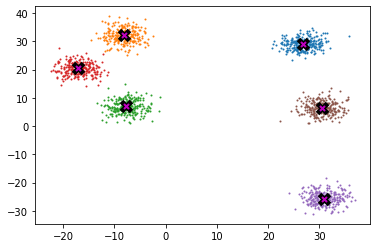

In [ ]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [14]:
midp = data.mean(0)
midp

NameError: name 'data' is not defined

In [15]:
plot_data([midp]*6, data, n_samples)

NameError: name 'plot_data' is not defined

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In [16]:
# def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

def gaussian(d, bw): return jnp.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [17]:
# def plot_func(f):
#     x = torch.linspace(0,10,100)
#     plt.plot(x, f(x))

def plot_func(f):
    x = jnp.linspace(0,10,100)
    plt.plot(x, f(x))

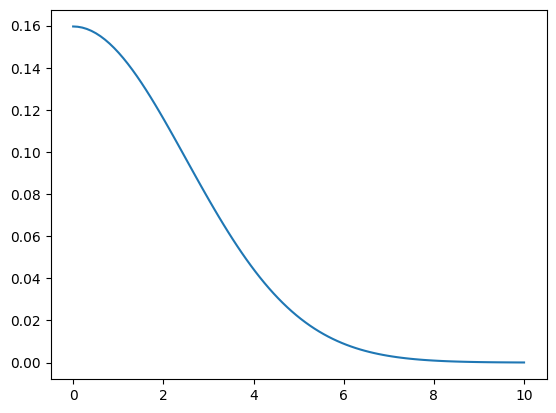

In [19]:
# plot_func(partial(gaussian, bw=2.5))
plot_func(curry(gaussian, bw=2.5))

In [21]:
# partial
curry

cytoolz.functoolz.curry

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [25]:
# def tri(d, i): return (-d+i).clamp_min(0)/i

def tri(d, i): return jnp.clip((-d+i), a_min=0)/i

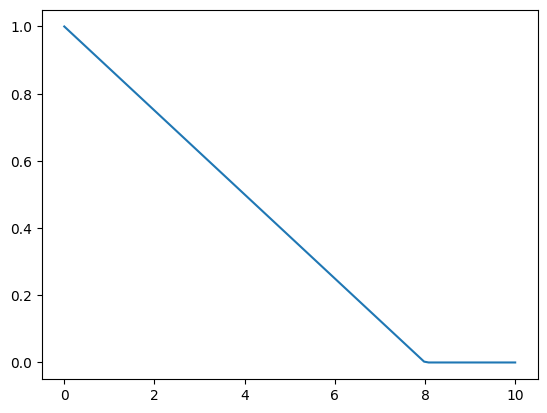

In [26]:
# plot_func(partial(tri, i=8))

plot_func(curry(tri, i=8))

In [27]:
X = data.clone()
x = data[0]

NameError: name 'data' is not defined

In [28]:
x

NameError: name 'x' is not defined

In [29]:
x.shape,X.shape,x[None].shape

NameError: name 'x' is not defined

In [30]:
(x[None]-X)[:8]

NameError: name 'x' is not defined

In [31]:
(x-X)[:8]

NameError: name 'x' is not defined

In [32]:
# rewrite using torch.einsum
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

NameError: name 'x' is not defined

In [33]:
weight = gaussian(dist, 2.5)
weight

NameError: name 'dist' is not defined

In [34]:
weight.shape,X.shape

NameError: name 'weight' is not defined

In [35]:
weight[:,None].shape

NameError: name 'weight' is not defined

In [36]:
weight[:,None]*X

NameError: name 'weight' is not defined

In [38]:
# def one_update(X):
#     for i, x in enumerate(X):
#         dist = torch.sqrt(((x-X)**2).sum(1))
# #         weight = gaussian(dist, 2.5)
#         weight = tri(dist, 8)
#         X[i] = (weight[:,None]*X).sum(0)/weight.sum()

def one_update(X):
    for i, x in enumerate(X):
        dist = jnp.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [39]:
# def meanshift(data):
#     X = data.clone()
#     for it in range(5): one_update(X)
#     return X

def meanshift(data):
    X = data.copy()
    for it in range(5): one_update(X)
    return X

In [43]:
%time X=meanshift(data)

NameError: name 'data' is not defined

In [44]:
plot_data(centroids+2, X, n_samples)

NameError: name 'plot_data' is not defined

## Animation

In [45]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [46]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [47]:
# create your own animation
# X = data.clone()
X = data.copy()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

NameError: name 'data' is not defined

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [48]:
bs=5
# X = data.clone()
X = data.copy()
x = X[:bs]
x.shape,X.shape

NameError: name 'data' is not defined

In [51]:
def dist_b(a,b): return jnp.sqrt((((a[None]-b[:,None])**2).sum(2)))

In [52]:
dist_b(X, x)

NameError: name 'X' is not defined

In [53]:
dist_b(X, x).shape

NameError: name 'X' is not defined

In [54]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

NameError: name 'X' is not defined

In [55]:
weight = gaussian(dist_b(X, x), 2)
weight

NameError: name 'X' is not defined

In [56]:
weight.shape,X.shape

NameError: name 'weight' is not defined

In [57]:
weight[...,None].shape, X[None].shape

NameError: name 'weight' is not defined

In [58]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

NameError: name 'weight' is not defined

In [59]:
num

NameError: name 'num' is not defined

In [60]:
# torch.einsum('ij,jk->ik', weight, X)
jnp.einsum('ij,jk->ik', weight, X)

NameError: name 'weight' is not defined

In [61]:
weight@X

NameError: name 'weight' is not defined

In [62]:
div = weight.sum(1, keepdim=True)
div.shape

NameError: name 'weight' is not defined

In [63]:
num/div

NameError: name 'num' is not defined

In [64]:
# def meanshift(data, bs=500):
#     n = len(data)
#     X = data.clone()
#     for it in range(5):
#         for i in range(0, n, bs):
#             s = slice(i, min(i+bs,n))
#             weight = gaussian(dist_b(X, X[s]), 2.5)
# #             weight = tri(dist_b(X, X[s]), 8)
#             div = weight.sum(1, keepdim=True)
#             X[s] = weight@X/div
#     return X

def meanshift(data, bs=500):
    n = len(data)
    X = data.copy()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [65]:
data = data.cuda()

NameError: name 'data' is not defined

In [66]:
X = meanshift(data).cpu()

NameError: name 'data' is not defined

In [67]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

NameError: name 'data' is not defined

In [68]:
plot_data(centroids+2, X, n_samples)

NameError: name 'plot_data' is not defined

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D